<a href="https://colab.research.google.com/github/yanli499/APS360-Project/blob/Lucy_1/YLL_VGG_16_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

YLL Test Code

In [0]:
# ALL import statements
import os
import shutil
import copy
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.autograd import Variable

In [2]:
# Mount our Google Drive
# re-run whenever needed
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# re-run when needed
# classes are folders in each directory with these names
classes = ['afraid','angry','disgusted','happy','neutral','sad','surprised']

# emotion label for KDEF photos
emotion_code = {"AF":"afraid", "AN":"angry", "DI":"disgusted", "HA":"happy", 
                "NE":"neutral", "SA":"sad", "SU":"surprised"}

data_dir='/content/drive/My Drive/Colab Notebooks/Faces'

In [4]:
# RUN ONLY ONCE!!!

# logic for sorting thru KDEF dataset for the images we want
"""
- eg file name: AF01ANFL.JPG
- Check:
    - length of name = 7, for straight profile only, ends with "S.jpg"
    - str[4:5] = {"AF":"afraid", "AN":"angry", "DI":"disgusted", "HA":"happy",
    "NE":"neutral", "SA":sad", "SU":"surprised"}
"""

# delete existing folder
if os.path.exists(data_dir+'/'):
    shutil.rmtree(data_dir+'/')

# make new directories for each emotion class + train, val, test
try:
    os.mkdir(data_dir)

    for i in range(len(classes)):
        os.mkdir(data_dir+'/'+classes[i])

    os.mkdir(data_dir+'/train')
    for i in range(len(classes)):
        os.mkdir(data_dir+'/train/'+classes[i])
    
    os.mkdir(data_dir+'/val')
    for i in range(len(classes)):
        os.mkdir(data_dir+'/val/'+classes[i])

    os.mkdir(data_dir+'/test')
    for i in range(len(classes)):
        os.mkdir(data_dir+'/test/'+classes[i])

except OSError:
    print ("Creation of the directories failed!")
else:
    print ("Successfully created the directories!")

# rootdir = path to KDEF main folder
rootdir = '/content/drive/My Drive/Colab Notebooks/PROJECT/KDEF/'

# go thru KDEF data + sort out desired photos
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filename = subdir + os.sep + file
        if (file.endswith("S.jpg") or file.endswith("S.JPG")): 
            # for each straight profile photo:
            # convert RGB --> Grayscale
            # resize to 256 x 256 pixels, b/c will center crop to 224 x 224 later
            # then save in the corresponding emotion class folder
            img = Image.open(filename).convert('L')
            new_img = img.resize((256, 256))

            if (file[4:6] == "AF"):
                new_img.save(data_dir+'/'+emotion_code["AF"]+'/'+file)
            elif (file[4:6] == "AN"):
                new_img.save(data_dir+'/'+emotion_code["AN"]+'/'+file)
            elif (file[4:6] == "DI"): 
                new_img.save(data_dir+'/'+emotion_code["DI"]+'/'+file)
            elif (file[4:6] == "HA"): 
                new_img.save(data_dir+'/'+emotion_code["HA"]+'/'+file)
            elif (file[4:6] == "NE"):
                new_img.save(data_dir+'/'+emotion_code["NE"]+'/'+file)
            elif (file[4:6] == "SA"): 
                new_img.save(data_dir+'/'+emotion_code["SA"]+'/'+file)
            elif (file[4:6] == "SU"):
                new_img.save(data_dir+'/'+emotion_code["SU"]+'/'+file)

Successfully created the directories!


In [0]:
# Split data into train, val, test datasets (60:20:20)
# each class = 140 images --> 84 train, 28 val, 28 test

# divide data into train, val, + test
# for each emotion class, get filenames, shuffle, 
# divide, move to corresponding folders in train, val, test
for c in classes:
    filepath = data_dir+'/'+c
    names = []

    for file in os.listdir(filepath):
        names.append(file)
    random.shuffle(names)

    # TODO: Can probably simplify this
    count = 0
    for name in names:
        if(count == (84-42)):
            break
        else:
            # shutil.move(dir1, dir2) = moves file form directory 1 to directory 2
            shutil.move(filepath+'/'+name, data_dir+'/train/'+c+'/'+name)
            names.remove(name)
            count += 1

    count = 0
    for name in names:
        if(count == (28-14)):
            break
        else:
            shutil.move(filepath+'/'+name, data_dir+'/val/'+c+'/'+name)
            names.remove(name)
            count += 1

    count = 0
    for name in names:
        if(count == (28-14)):
            break
        else:
            shutil.move(filepath+'/'+name, data_dir+'/test/'+c+'/'+name)
            names.remove(name)
            count += 1

In [0]:
# crop all images to 224 x 224 for all datasets
# generate image folders + data loaders for train, val, test
def generate_train_val_test_datasets(batch_size=30):
    data_transform = transforms.Compose([
                                        transforms.CenterCrop(224), 
                                        transforms.ToTensor()
                                        ])

    image_datasets = {
        'train': datasets.ImageFolder(
            os.path.join(data_dir, 'train/'), 
            transform=data_transform
        ),
        'val': datasets.ImageFolder(
            os.path.join(data_dir, 'val/'), 
            transform=data_transform
        ),
        'test': datasets.ImageFolder(
            os.path.join(data_dir, 'test/'), 
            transform=data_transform
        )
    }

    data_loaders = {
        'train': torch.utils.data.DataLoader(
            image_datasets['train'], batch_size=batch_size
        ),
        'val': torch.utils.data.DataLoader(
            image_datasets['val'], batch_size=batch_size
        ),
        'test': torch.utils.data.DataLoader(
            image_datasets['test'], batch_size=batch_size
        )
    }

    # get size of each dataset
    dataset_sizes = {
        'train': len(image_datasets['train']),
        'val': len(image_datasets['val']),
        'test': len(image_datasets['test']) 
    }

    return image_datasets, data_loaders, dataset_sizes

In [0]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        imgs = vgg16.features(imgs) # take images, overwrite w alexnet features, then use the image in our training
        # running feature extraction on each batch in each for loop --> inefficient / slow,
        # should run on whole data set 1st, save the extracted features in folder, then load for training
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [0]:
def train(model, data_loaders, batch_size, num_epochs=1):
    train_loader = data_loaders['train']
    val_loader = data_loaders['val']

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
            imgs = features = vgg16.features(imgs)
            print(n)            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [0]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(512 * 7 * 7, 100)
        self.fc2 = nn.Linear(100, 7) # only 1 hidden layer, 10 hidden units --> will need more to be accurate

    def forward(self, x):
        x = x.view(-1, 512 * 7 * 7) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

0
1
2
3
4
5
6
7
8
9


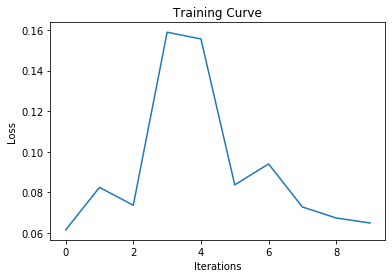

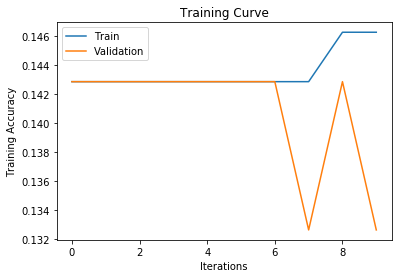

Final Training Accuracy: 0.14625850340136054
Final Validation Accuracy: 0.1326530612244898


In [26]:
# generate training datasets
batch_size = 30
image_datasets, data_loaders, dataset_sizes = generate_train_val_test_datasets(batch_size)

# get pretrained vgg16 model
vgg16 = torchvision.models.vgg16(pretrained=True)

# train model with transfer learning
model = ANNClassifier()
train(model, data_loaders, batch_size, num_epochs=1)